# 2. 임베딩

## 2.1 임베딩이란?

* `자연어를 숫자나 벡터형태로 변환하는 것`을 임베딩이라고 한다.
* 즉, 임베딩은 `단어나 문장을 수치화해서 벡터공간으로 표현하는 과정`을 의미한다.

##### 임베딩기법
1. 문장임베딩 : 문장전체를 벡터로 표현
   - 문장의 흐름을 벡터화하기 때문에 문맥적의미를 가지는 장점이 있다.
   - 하지만 임베딩을 하기 위해서는 많은 문장이 필요하며 학습비용이 많이 든다.
   - 상용시스템에서 많이 사용된다.(단어임베딩에 비해 품질이 좋다)
1. 단어임베딩 : 개별 단어를 벡터로 표현
   - 동음의의어에 대한 구분을 하지 않는다.
   - 그렇기 때문에 의미가 다르더라도 단어형태가 같다면 동일한 벡터값으로 표현하는 단점이 있다.
   - 하지만, 문장임베딩에비해 학습이 간단하여 실무에 많이 사용된다.

## 2.2 단어임베딩

* 단어 임베딩은 말뭉치에서 각각의 단어를 벡터로 변환하는 기법을 의미
* 참고 : https://wikidocs.net/33520

### 2.2.1 원핫인코딩(One-Hot Encoding)

* `단어를 숫자벡터로 변환하는 가장 기본적인 방법`
* 단 하나의 값만 1이고 나머지는 0인 희소행렬
* 원핫인코딩의 결과를 원핫벡터라고 하고 `희소벡터(sparse vecto), 희소행렬`이라고 한다.

In [4]:
# 원핫인코딩
import numpy as np
from konlpy.tag import Komoran

komoran = Komoran()
text = "오늘 날씨는 구름이 많아요"

# 명사만 추출
nons = komoran.nouns(text)
print(nons)

# 단어사전구축 및 단어별 인덱스부여
dics = {}
for word in nons:
    if word not in dics.keys():
        dics[word] =  len(dics)
print(dics)

# 단어벡터화 - 원핫인코딩
nb_classes = len(dics)
targets = list(dics.values())
print(nb_classes, targets)

# np.eyts()함수는 원핫벡터를 생성하는 함수
one_hot_targets = np.eye(nb_classes)[targets]
print(one_hot_targets)

# 결과
# [1. 0. 0.]이란 값이 입력되면 '오늘'이라고 인식이 가능
# 원핫인코딩의 메모리낭비와 계산의 복잡도가 커진다.

['오늘', '날씨', '구름']
{'오늘': 0, '날씨': 1, '구름': 2}
3 [0, 1, 2]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### 2.2.2 희소표현과 분산표현

* 희소표현은 `희소벡터로 표현되는 방식`, 분산표현은 `단어간의 유사성을 표현 방법`
* 분산표현은 `데이터손실을 최소화하면서 벡터차원을 압축되는 효과`라 있다.
* 분산표현을 원하는 차원에 데이터를 최대한 밀집시켜서 `밀집표현`이라고도 한다.
* 참고: http://bigdata.dongguk.ac.kr/lectures/TextMining/_book/분산표현.html

### 2.2.3 Word2Vec

* 신경망기반의 `단어임베딩의 대표적인 방법`이다.
* Word2Vec은 2013년에 구글에서 발표, 가장 많이 사용하는 모델이다.
* Word2Vec 모델은 `CBOW(Continuos Bag-Of-Words)와 skip-gram` 두 가지 모델로 제안되었다.
  - CBOW는 `주변 단어를 이용해 타킷단어를 예측`하는 모델
  - skip-gram은 CBOW와 반대로 `하나의 타깃단어를 이용해 주변 단어를 예측`하는 모델
* Word2Vec은 `단어를 밀집벡터로 표현`하고 학습을 통해서 `유사한 단어를 가까운 벡터공간에 위치`시킨다.
* Word2Vec은 오픈소스라이브러리 `Gensim패키지를 사용`하고 `한국어 말뭉치는 네이버영화리뷰테이터를 사용`
  1. gensim : pip install gensim
  1. 네이버영화리뷰테이터 (Naver Sentiment Movee Corpus, NSMC)
     - 최신버전 : http://github.com/e9t/nsmc

In [ ]:
# nvmc.modle 생성 및 저장
from gensim.models import Word2Vec
from konlpy.tag import Komoran
import time

# 네이버영화리뷰데이터 읽기
def read_review_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line  in f.read().splitlines()]
        data = data[1:]  # header부분제거
    return data

# 학습시간측정 - 시작시간
start = time.time()

# 1. 파일읽기
review_data = read_review_data('./data/chatbot/ratings.txt')
print('1) 말뭉치데이터 읽기 소요시간 = ', time.time() - start, " 데이터건수 = ", len(review_data))

# 2. 문장단위로 명사만 추출 - 학습을 위한 입력데이터로 사용
komoran = Komoran()
docs = [komoran.nouns(sentence[1]) for sentence in review_data]
print('2) 형태소에서 명사만 추출소요시간 = ', time.time() - start, "데이터건수 = ", len(docs))

In [12]:
# 3. Word2Vec모델학습
#    - sentences : word2vec모델 학습에 필요한 문장데이터
#    - vector_size : 단어 임베딩 벡터의 차원(크기)
#    - window : 주변 단어 윈도우의 크기
#    - hs : 1(모델학습에 softmax 사용), 0(negative 옵션값이 0이 아닐 떄 음수 샘플링으로 사용)
#    - min_count : 단어 최소 빈도수 제한(설정된 빈도수 이하의 단어들은 학습하지 않음)
#    - sg : 0(CBOW모델), 1(skip-gram 모델)
start = time.time()
model = Word2Vec(sentences=docs, vector_size=200, window=4, hs=1, min_count=2, sg=1)
print('3) Word2Vec 학습 소요시간 = ', time.time() - start)

3) Word2Vec 학습 소요시간 =  20.656609773635864


In [13]:
# 4. 모델저장
start = time.time()
model.save('./data/chatbot/nvmc.model')
print('4) Word2Vec 모델 저장시간 = ', time.time() - start)

4) Word2Vec 모델 저장시간 =  0.8207898139953613


In [14]:
# 5. 결과 - 학습된 말뭉치의 갯수, 말뭉치(코퍼스)내의 전체 단어갯수
print('5) 학습된 말뭉치 갯수 = ', model.corpus_count)
print('6) 말뭉치내의 전체 단어 갯수 = ', model.corpus_total_words)

5) 학습된 말뭉치 갯수 =  200000
6) 말뭉치내의 전체 단어 갯수 =  1076896


In [21]:
# 6. 학습된 모델을 이용한 단어의 유사성
# 1) 모델로딩
model = Word2Vec.load('./data/chatbot/nvmc.model')

# 2) 사랑이란 단어로 생성한 단어임베딩벡터
print('사랑 : ', model.wv['사랑'], '사랑단어갯수 = ',  len(model.wv['사랑']))

사랑 :  [-0.07736067 -0.4874356   0.1080528  -0.25186986 -0.01341268 -0.17545193
 -0.14038987  0.20248112 -0.03560618 -0.0888937  -0.02824287  0.04229235
  0.05645616  0.01507786 -0.15748705  0.38919023 -0.06439799  0.06439406
 -0.23248038 -0.20689295 -0.04537183  0.22390999 -0.25081602 -0.03840152
 -0.20173913 -0.07686015  0.10328924 -0.17701328 -0.19586848  0.08129189
 -0.00824896 -0.05871371 -0.2037521  -0.22467224  0.37577322  0.43686563
  0.21946669 -0.3109965  -0.16290548 -0.09589966 -0.16072476  0.23733327
 -0.3350241  -0.2757078   0.32165706  0.02089363 -0.06771979  0.1643078
  0.18925098 -0.10843629  0.01767442 -0.20807524 -0.00960846 -0.02941534
  0.14119972 -0.08809616  0.46416882  0.01592584  0.1523239   0.1534374
 -0.00105183  0.14914763 -0.32359722  0.00890845 -0.07102908  0.01067204
 -0.3066147   0.20897071  0.08780772  0.36822194 -0.18533684 -0.18866995
  0.12147319 -0.12749659  0.03273203 -0.0349843   0.23433724 -0.20996621
 -0.27869788  0.09993868  0.07446159  0.0200011

In [27]:
# 3) 단어유사도 : model.wv.similarity()함수
print("일요일과 월요일의 유사도 = ", model.wv.similarity(w1='일요일', w2='월요일'))
print("황정민과 배우의 유사도 = ", model.wv.similarity(w1='황정민', w2='배우'))
print("안성기와 배우의 유사도 = ", model.wv.similarity(w1='안성기', w2='배우'))
print("정우성과 배우의 유사도 = ", model.wv.similarity(w1='정우성', w2='배우'))
print("대기업과 삼성과의 유사도 = ", model.wv.similarity(w1='대기업', w2='삼성'))
print("일요일과 삼성과의 유사도 = ", model.wv.similarity(w1='일요일', w2='삼성'))

일요일과 월요일의 유사도 =  0.6491535
황정민과 배우의 유사도 =  0.5240203
안성기와 배우의 유사도 =  0.5563992
정우성과 배우의 유사도 =  0.48632556
대기업과 삼성과의 유사도 =  0.5078534
일요일과 삼성과의 유사도 =  0.24541697


In [30]:
# 4) most_similar(topn) - 가장 유사한 단어 추출
#   topn=5 : 5개까지 유사한 단어갯수
print(model.wv.most_similar("안성기", topn=5))
print(model.wv.most_similar("시리즈", topn=5))

[('씨야', 0.7094363570213318), ('장미희', 0.7033339738845825), ('정재영', 0.7026819586753845), ('박중훈', 0.6978691816329956), ('설경구', 0.6962516903877258)]
[('나니아 연대기', 0.6565300226211548), ('캐리비안의 해적', 0.6378832459449768), ('X맨', 0.6313600540161133), ('데스티네이션', 0.6273446083068848), ('더 울버린', 0.6271237134933472)]


In [31]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 한글처리
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False

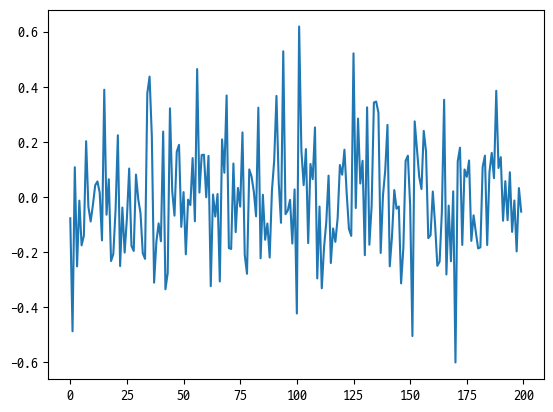

In [36]:
# 시각화
plt.plot(model.wv['사랑'])
plt.show()

# 결과분석
# 사랑이란 단어는 모든 차원에 골고루 분포되어 있다.
# 즉, 사랑이란 단어는 모든 벡터와 관계가 있음을 유추할 수 있다.
# 안성기라는 단어는 배우라는 단어의 유사도가 57%, 일요일과 월요일은 64%유사도가 있다.
# 유사도가 1에 가까울 수록 두 단어는 동일의미이거나 문법적관계가 있을 확률이 높다.